# Pandas Example: Organizing sequence data for time-series forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

This example is based on the following user's stackoverflow question:

- https://stackoverflow.com/questions/58544615/transformation-of-data-for-the-multi-step-sequence-for-lstm-timeseries/58545357#58545357

Suppose we have some price data from customers that looks like this:

In [2]:
%%writefile data.txt
Date,Customer,Price
1/6/2019,A,855
1/7/2019,A,989
1/8/2019,A,454
1/9/2019,A,574
1/10/2019,A,395
1/1/2019,A,162
1/2/2019,A,123
1/3/2019,A,342
1/4/2019,A,232
1/5/2019,A,657
1/6/2019,B,875
1/7/2019,B,999
1/8/2019,B,434
1/9/2019,B,564
1/10/2019,B,345
1/10/2019,B,798
1/6/2019,B,815
1/7/2019,B,929
1/8/2019,B,444
1/9/2019,B,554
1/10/2019,B,395
1/10/2019,B,768

Overwriting data.txt


We want to try to predict future prices from recent prices from the same customer.  To do this we want to sort the data into convenient tuples, short sequences of data items that contain the data we will use for training and testing a price-forecasting algorithm.

## 1. Load and analyse the data

In [3]:
# Read in the data
df = pd.read_csv('data.txt', index_col=0)
df = df.reset_index()
df.head()

,Date,Customer,Price
0,1/6/2019,A,855
1,1/7/2019,A,989
2,1/8/2019,A,454
3,1/9/2019,A,574
4,1/10/2019,A,395


In [4]:
prices_by_customers = df.groupby('Customer')['Price']
customers = [name for name, prices in prices_by_customers]
price_sequences = pd.concat([prices.reset_index(drop=True) for name, prices in prices_by_customers], 
                            axis=1, keys=customers)
price_sequences

,A,B
0,855.0,875
1,989.0,999
2,454.0,434
3,574.0,564
4,395.0,345
5,162.0,798
6,123.0,815
7,342.0,929
8,232.0,444
9,657.0,554


In [5]:
# Check how much data per customer
price_sequences.count()

A    10
B    12
dtype: int64

## 2. Process data for time-series analysis

In [6]:
# Add shifted columns
x_data = []
y_data = []
for customer, prices in prices_by_customers:
    x = {i: prices.shift(-i) for i in range(4)}
    y = {i: prices.shift(-i-4) for i in range(2)}
    x['Customer'] = customer
    y['Customer'] = customer
    x_data.append(pd.DataFrame(x))
    y_data.append(pd.DataFrame(y))

In [7]:
x_data = pd.concat(x_data)
y_data = pd.concat(y_data)
pd.concat([x_data, y_data], axis=1)

,0,1,2,3,Customer,0,1,Customer
0,855,989.0,454.0,574.0,A,395.0,162.0,A
1,989,454.0,574.0,395.0,A,162.0,123.0,A
2,454,574.0,395.0,162.0,A,123.0,342.0,A
3,574,395.0,162.0,123.0,A,342.0,232.0,A
4,395,162.0,123.0,342.0,A,232.0,657.0,A
5,162,123.0,342.0,232.0,A,657.0,NaN,A
6,123,342.0,232.0,657.0,A,NaN,NaN,A
7,342,232.0,657.0,NaN,A,NaN,NaN,A
8,232,657.0,NaN,NaN,A,NaN,NaN,A
9,657,NaN,NaN,NaN,A,NaN,NaN,A


In [8]:
# Finally, drop NaNs etc.:
training_data = pd.concat([x_data, y_data], axis=1, keys=['X_data', 'y_data']).dropna()
training_data = training_data.reset_index(drop=True).drop(('y_data', 'Customer'), axis=1)
training_data

X_data                               y_data       
        0      1      2      3 Customer      0      1
0     855  989.0  454.0  574.0        A  395.0  162.0
1     989  454.0  574.0  395.0        A  162.0  123.0
2     454  574.0  395.0  162.0        A  123.0  342.0
3     574  395.0  162.0  123.0        A  342.0  232.0
4     395  162.0  123.0  342.0        A  232.0  657.0
5     875  999.0  434.0  564.0        B  345.0  798.0
6     999  434.0  564.0  345.0        B  798.0  815.0
7     434  564.0  345.0  798.0        B  815.0  929.0
8     564  345.0  798.0  815.0        B  929.0  444.0
9     345  798.0  815.0  929.0        B  444.0  554.0
10    798  815.0  929.0  444.0        B  554.0  395.0
11    815  929.0  444.0  554.0        B  395.0  768.0

## 3. Split the data into train and test sets

In [9]:
from sklearn.model_selection import train_test_split

x = training_data['X_data'].drop('Customer', axis=1)  # Ignore customer label
y = training_data['y_data']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

x_train.shape, y_train.shape

((9, 4), (9, 2))

In [10]:
x_test.shape, y_test.shape

((3, 4), (3, 2))

## 4. Train the model

In [11]:
from sklearn.linear_model import LinearRegression

In [19]:
reg = LinearRegression().fit(x_train, y_train)

## 5. Test the model on the test data

In [20]:
from sklearn.metrics import r2_score

y_pred = reg.predict(x_test)
y_pred = pd.DataFrame(y_pred, index=x_test.index)

pd.concat([y_test, y_pred], axis=1, keys=['True values', 'Predictions'])

True values        Predictions            
             0      1           0           1
6        798.0  815.0  403.687005  152.688208
11       395.0  768.0  362.484290  507.811818
4        232.0  657.0  512.093026  451.835048

In [21]:
r2_score(y_test, y_pred)

-20.522339744877144

Note: If $R^2$ < 0.5 then it is a poor model...

In [22]:
# Model coefficients
reg.coef_

array([[-0.01495939, -0.38983674,  0.0102233 ,  0.7188552 ],
       [-0.3296829 ,  0.25102598, -0.38566046,  0.59294182]])

In [23]:
reg.intercept_ 

array([334.0495906, 386.0437169])

## 6. Make predictions

In [24]:
# Get some price data
x = np.array([400, 450.0, 500.0, 550.0])

prediction = reg.predict(x.reshape(1, -1))[0, :]
prediction

array([553.12131744, 500.42002154])

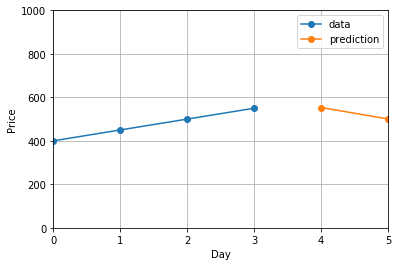

In [25]:
pd.Series(x, name='data').plot(style='o-')
pd.Series(prediction, index=[4, 5], name='prediction').plot(style='o-')
plt.ylim(0,1000)
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()